In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Data visualizations

In [2]:
df = pd.read_csv('kaggle/input/data/Data_Entry_2017.csv')

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


C:\Users\91805\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Amount of occurrences')]

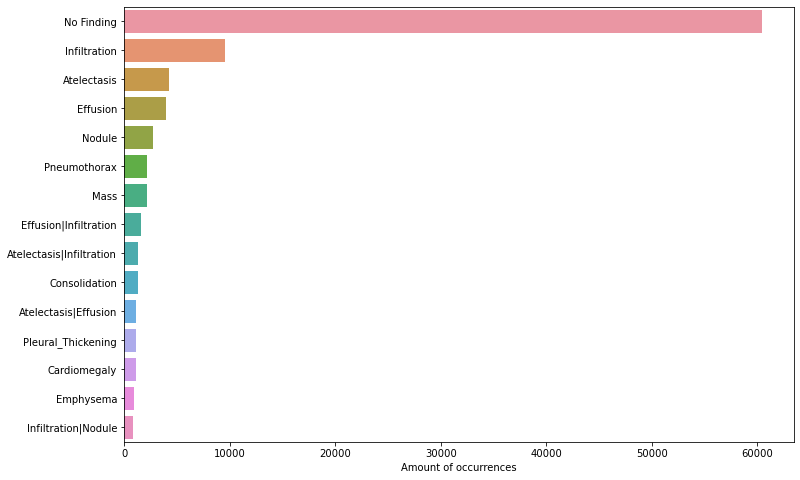

In [3]:
labels_count = df['Finding Labels'].value_counts()[:15]
plt.subplots(figsize=(12, 8))
ax = sns.barplot(labels_count, labels_count.index)
ax.set(xlabel='Amount of occurrences')

### Small label preparation

In [4]:
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
y = []
for x in df['Finding Labels'].unique():
    splitted = x.split('|')
    y = np.append(y, splitted)

y = [x for x in y if len(x) > 0]
y = np.unique(y)
print('All labels ({}): {}'.format(len(y), y))

All labels (14): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'Nodule'
 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [5]:
for label in y:
    df[label] = df['Finding Labels'].map(lambda x: 1.0 if label in x else 0.0)

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,081Y,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### More data visualizations

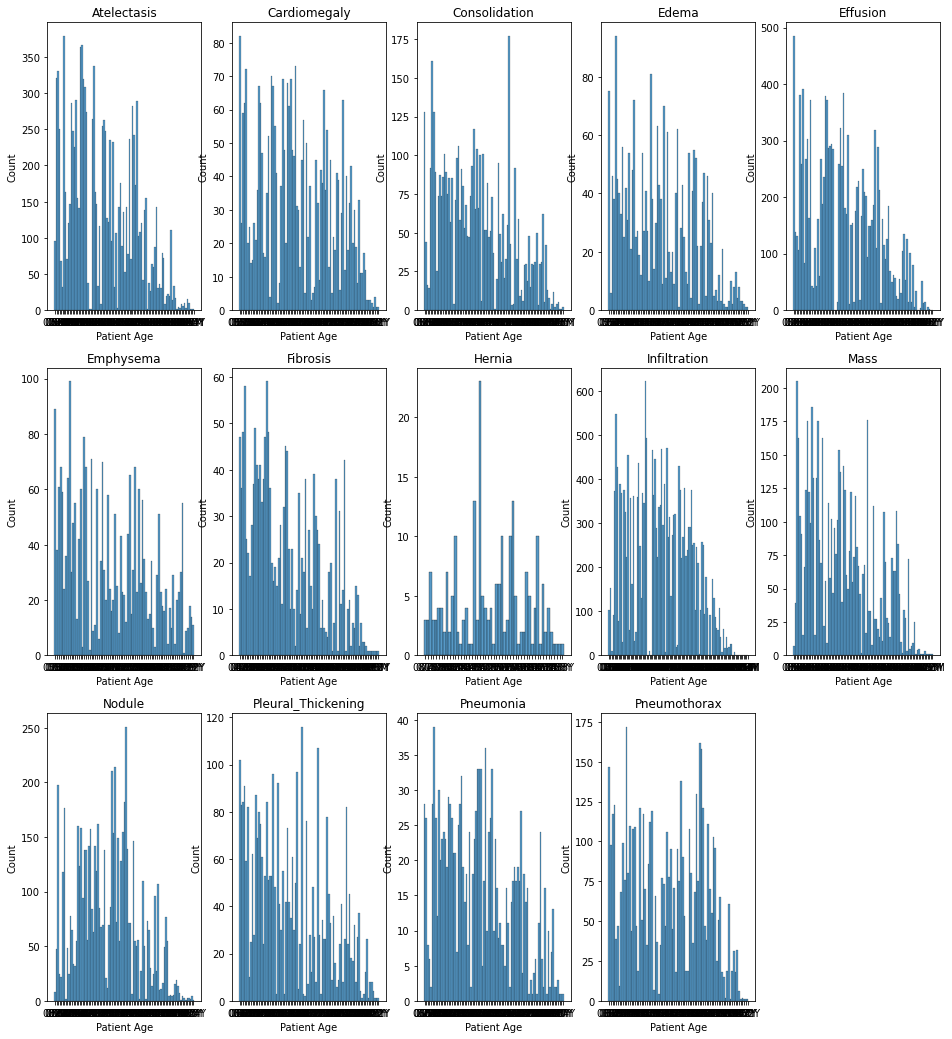

In [6]:
plt.figure(figsize=(16, 18))
for i, column in enumerate(df[y]):
    plt.subplot(3, 5, i+1)
    plt.title(column)
    sns.histplot(df[df[column].where(df[column] == 1.0).notnull()]['Patient Age'])    

### Display example images

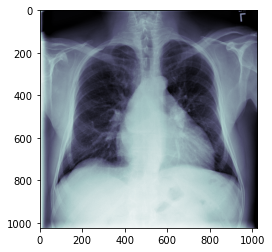

In [7]:
import matplotlib.image as mpimg

img = mpimg.imread('kaggle/input/data/images_001/images/00000001_000.png')
imgplot = plt.imshow(img, cmap='bone')
plt.show()

In [8]:
def get_corresponding_label(image_index):
    return y[df.loc[df['Image Index'] == image_index][y].values.argmax()]

get_corresponding_label('00000001_000.png')

'Cardiomegaly'

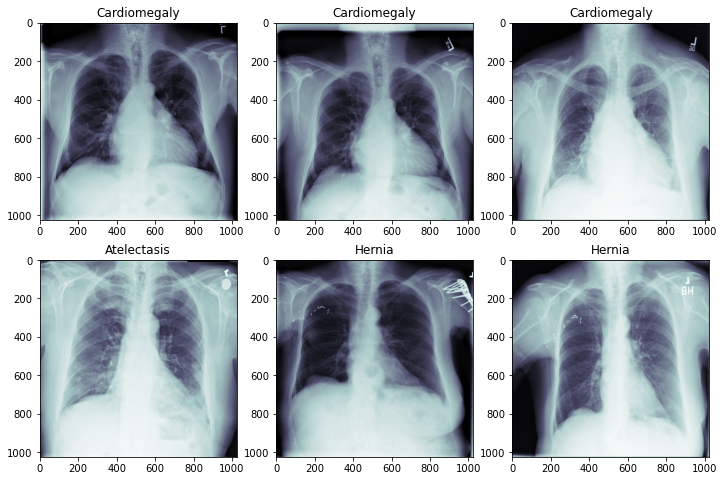

In [9]:
def show_images(path='kaggle/input/data', extension='/images_001/images', labeled=False, max_images=6):
    amount = 0
    fig = plt.figure(figsize=(12, 8))
    
    for file in os.listdir(path + extension):
        if file.endswith('.png'):
            if amount == max_images:
                break
            
            img = mpimg.imread(os.path.join(path + extension, file))
            plt.subplot(231+amount)
            if labeled:
                plt.title(get_corresponding_label(file))
            imgplot = plt.imshow(img, cmap='bone')
            
            amount += 1

show_images(labeled=True)

## Prepare the training data

This will store every result of the given data in one single vector. Basically, we store what the model will try to predict.

In [10]:
#df['disease_vec'] = df.apply(lambda x: [x[y].values], 1).map(lambda x: x[0])
#df['disease_vec'].head()

In [11]:
df.shape

(112120, 26)

In [16]:
df = df[df['Patient Age'] < '100Y']
df_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('kaggle/input/data', 'images*', '*', '*.png'))}
print('Scans found:', len(df_image_paths), ', Total Headers', df.shape[0])
df['path'] = df['Image Index'].map(df_image_paths.get)
df['Patient Age'] = df['Patient Age'].map(lambda x: int(x[:-1]))

Scans found: 112120 , Total Headers 112104


In [17]:
new_df = df.sample(30000)

In [18]:
import cv2
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    return img

from tqdm import tqdm
train_img = []
for img_path in tqdm(new_df['path'].values):
    train_img.append(read_img(img_path))

100%|██████████| 30000/30000 [46:13<00:00, 10.82it/s]  


In [19]:
X = np.array(train_img, np.float32)/255

In [20]:
Y = new_df[y].values

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.25,
    random_state=2018
)
print('train', X_train.shape[0], 'val', X_test.shape[0])

train 22500 val 7500


In [22]:
del X
del Y

In [23]:
X_train.shape

(22500, 128, 128, 3)

In [24]:
Y_train.shape

(22500, 14)

In [28]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential

base_mobilenet_model = MobileNet(
    input_shape=(128, 128, 3), 
    include_top=False,
    weights=None
)
model = Sequential()
model.add(base_mobilenet_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(Dense(len(y), activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy', 'mae']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                7182      
Total params: 3,760,846
Trainable params: 3,738,958
Non-trainable params: 21,888
_________________________________________

In [31]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=True
)

early = EarlyStopping(
    monitor="val_loss", 
    mode="min", 
    patience=3
)

callbacks_list = [checkpoint, early]

In [33]:
early_stops = EarlyStopping(patience=3, monitor='val_accuracy')

model.fit(
    x=X_train,
    y=Y_train,
    batch_size=100,
    epochs=5,
    validation_split=0.3,
    callbacks=[early_stops]
)

Epoch 1/5
158/158 [==============================] - 383s 2s/step - loss: 0.1818 - binary_accuracy: 0.9483 - mae: 0.0927 - val_loss: 0.2356 - val_binary_accuracy: 0.9489 - val_mae: 0.0593
Epoch 2/5
158/158 [==============================] - 386s 2s/step - loss: 0.1788 - binary_accuracy: 0.9484 - mae: 0.0918 - val_loss: 0.1986 - val_binary_accuracy: 0.9489 - val_mae: 0.0704
Epoch 3/5
158/158 [==============================] - 383s 2s/step - loss: 0.1765 - binary_accuracy: 0.9484 - mae: 0.0913 - val_loss: 0.1865 - val_binary_accuracy: 0.9489 - val_mae: 0.0755
Epoch 4/5
158/158 [==============================] - 383s 2s/step - loss: 0.1738 - binary_accuracy: 0.9485 - mae: 0.0903 - val_loss: 0.1897 - val_binary_accuracy: 0.9468 - val_mae: 0.1204
Epoch 5/5
158/158 [==============================] - 353s 2s/step - loss: 0.1727 - binary_accuracy: 0.9485 - mae: 0.0900 - val_loss: 0.1842 - val_binary_accuracy: 0.9479 - val_mae: 0.0831


In [34]:
for c_label, s_count in zip(y, 100*np.mean(Y_test, 0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 10.53%
Cardiomegaly: 2.75%
Consolidation: 4.37%
Edema: 1.79%
Effusion: 12.71%
Emphysema: 2.08%
Fibrosis: 1.43%
Hernia: 0.21%
Infiltration: 17.57%
Mass: 4.83%
Nodule: 5.56%
Pleural_Thickening: 2.89%
Pneumonia: 1.35%
Pneumothorax: 4.80%


In [35]:
pred_Y = model.predict(X_test, batch_size=32, verbose=True)

235/235 [==============================] - 26s 109ms/step


### ROC Curves

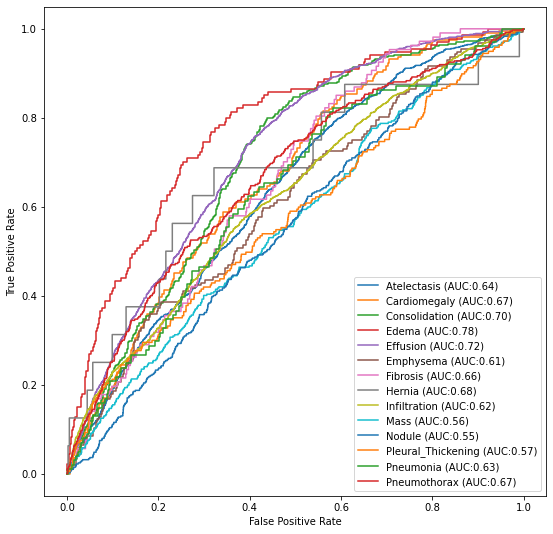

In [36]:
from sklearn.metrics import roc_curve, auc

fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))

for (idx, c_label) in enumerate(y):
    fpr, tpr, thresholds = roc_curve(Y_test[:, idx].astype(int), pred_Y[:, idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

### Continue training

In [37]:
early_stops = EarlyStopping(patience=3, monitor='val_acc')

model.fit(x=X_train, y=Y_train, batch_size=100, epochs=8, validation_split=0.3, callbacks=[early_stops])

Epoch 1/8
158/158 [==============================] - 269s 2s/step - loss: 0.1707 - binary_accuracy: 0.9484 - mae: 0.0896 - val_loss: 0.1761 - val_binary_accuracy: 0.9483 - val_mae: 0.0854
Epoch 2/8
158/158 [==============================] - 269s 2s/step - loss: 0.1685 - binary_accuracy: 0.9485 - mae: 0.0884 - val_loss: 0.1785 - val_binary_accuracy: 0.9482 - val_mae: 0.0947
Epoch 3/8
158/158 [==============================] - 270s 2s/step - loss: 0.1666 - binary_accuracy: 0.9486 - mae: 0.0882 - val_loss: 0.1791 - val_binary_accuracy: 0.9461 - val_mae: 0.1006
Epoch 4/8
158/158 [==============================] - 269s 2s/step - loss: 0.1652 - binary_accuracy: 0.9485 - mae: 0.0877 - val_loss: 0.1990 - val_binary_accuracy: 0.9479 - val_mae: 0.0687
Epoch 5/8
158/158 [==============================] - 270s 2s/step - loss: 0.1642 - binary_accuracy: 0.9487 - mae: 0.0870 - val_loss: 0.1805 - val_binary_accuracy: 0.9488 - val_mae: 0.0905
Epoch 6/8
158/158 [==============================] - 269s 2s

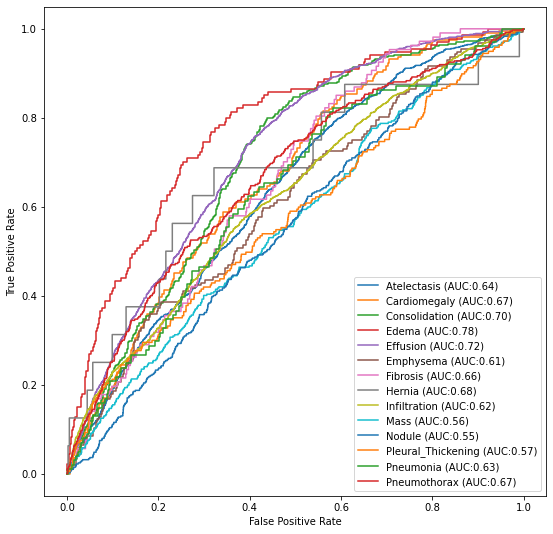

In [38]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(y):
    fpr, tpr, thresholds = roc_curve(Y_test[:, idx].astype(int), pred_Y[:, idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

## Save the model to disk

In [39]:
model_json = model.to_json()
with open("multi_disease_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("multi_disease_model_weight.h5")
print("Saved model to disk")

Saved model to disk
